the design of a neural network that can discover binding motifs in DNA based on the results of an assay that determines whether a longer DNA sequence binds to the protein or not. Here, the longer DNA sequences are our independent variables (or predictors), while the positive or negative response of the assay is the dependent variable (or response).

We will use simulated data that consists of DNA sequences of length 50 bases (chosen to be artificially short so that the data is easy to use), and is labeled with 0 or 1 depending on the result of the assay. Our goal is to build a classifier that can predict whether a particular sequence will bind to the protein and discover the short motif that is the binding site in the sequences that are bound to the protein.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, LSTM, Embedding, Lambda
from tensorflow.keras.models import Model, Sequential
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import requests

In [2]:
SEQUENCES_URL = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/sequences.txt'
sequences = requests.get(SEQUENCES_URL).text.split('\n')
sequences = list(filter(None, sequences))

pd.DataFrame(sequences, index=np.arange(1, len(sequences)+1),
             columns=['Sequences']).head()

,Sequences
1,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...
2,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...
3,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...
4,GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...
5,GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...


In [3]:
#one-hot encoding
label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(categories='auto')
input_features = []

for sequence in sequences:
    integer_encoded = label_encoder.fit_transform(list(sequence))
    integer_encoded = np.array(integer_encoded).reshape(-1, 1)
    one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
    input_features.append(one_hot_encoded.toarray())

input_features = np.stack(input_features)
input_features.shape

(2000, 50, 4)

In [4]:
np.set_printoptions(threshold=40)
input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)

Example sequence
-----------------------
DNA Sequence #1:
 CCGAGGGCTA ... CGCGGACACC
One hot encoding of Sequence #1:
 [[0. 0. 0. ... 1. 0. 0.]
 [1. 1. 0. ... 0. 1. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [5]:
#labels
LABELS_URL = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/labels.txt'
labels = requests.get(LABELS_URL).text.split('\n')
labels = list(filter(None, labels))

labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()
print('Labels:\n',labels.T)
print('One-hot encoded labels:\n',input_labels.T)

Labels:
 [['0' '0' '0' ... '0' '1' '1']]
One-hot encoded labels:
 [[1. 1. 1. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]]


In [6]:
train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, input_labels, test_size=0.25, random_state=42)

# VAE
latent_dim = 16  # dimensionality of the latent space
input_shape = train_features.shape[1:]  # shape of the input DNA sequences

In [7]:
# encoding
inputs = Input(shape=input_shape)
x = Conv1D(filters=32, kernel_size=12, activation='relu', padding='same')(inputs)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

In [8]:
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

In [9]:
# decoding
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(64, activation='relu')(latent_inputs)
x = Dense(np.prod(input_shape), activation='relu')(x)
x = tf.keras.layers.Reshape(input_shape)(x)
x = Conv1D(filters=32, kernel_size=12, activation='relu', padding='same')(x)
outputs = Dense(4, activation='softmax')(x)

In [10]:
# VAE model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
decoder = Model(latent_inputs, outputs, name='decoder')
vae_outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, vae_outputs, name='vae')

In [11]:
# Loss function
vae.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=['binary_accuracy'])
vae.summary()


Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 50, 4)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Functional)                 │ [(None, 16), (None, 16),    │          54,912 │
│                                      │ (None, 16)]                 │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 50, 4)               │          15,788 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 70,700 (276.17 KB)

 Trainable params: 70,700 (276.17 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
vae.fit(train_features, train_features, epochs=50, batch_size=32, validation_split=0.2)

def generate_sequences(num_sequences=10):
    latent_samples = np.random.normal(size=(num_sequences, latent_dim))
    generated_sequences = decoder.predict(latent_samples)
    return generated_sequences

new_sequences = generate_sequences(10)
print("Generated DNA Sequences (One-hot encoded):")
print(new_sequences)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - binary_accuracy: 0.7498 - loss: 0.6638 - val_binary_accuracy: 0.7499 - val_loss: 0.5683
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.7500 - loss: 0.5653 - val_binary_accuracy: 0.7500 - val_loss: 0.5637
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.7500 - loss: 0.5625 - val_binary_accuracy: 0.7500 - val_loss: 0.5628
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - binary_accuracy: 0.7500 - loss: 0.5617 - val_binary_accuracy: 0.7500 - val_loss: 0.5624
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.7500 - loss: 0.5616 - val_binary_accuracy: 0.7500 - val_loss: 0.5621
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.7500 - loss: 0.5611 - val_binary_accuracy: 0.7500 - val_loss: 0.5617
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.7500 - loss: 0.5608 - val_binary_accuracy: 0.7500 - val_loss: 0.5611
Epoch 8/50
38/38 ━━

In [13]:
# numerical sequence back to DNA sequence (A=0, T=1, C=2, G=3)
def decode_sequence(sequence):
    mapping = {0: 'A', 1: 'T', 2: 'C', 3: 'G'}
    # convert one-hot encoded sequence to integer sequence
    integer_sequence = np.argmax(sequence, axis=1)
    return ''.join([mapping[n] for n in integer_sequence])

decoded_sequences = [decode_sequence(seq) for seq in new_sequences]

print("Generated DNA Sequences:")
for seq in decoded_sequences:
    print(seq)

Generated DNA Sequences:
GGGGGCAGCCAGGGCAGGGGGGGGGGGGAGGCAAGGGGCGGTCAAAGGGG
GGGAAGCGACGGGGAAGGGGGAGGGGGGGGGGGGGCAAGGAGGGGGGAGG
GGGGGGACCCAAAAAAGGGGGGAGGGGGAAGGAAGGCAAGGGGGGGGGAG
AGGGGGCGCCCAGGCAAGGGGAAGGGGGGGAAAGGGAAGGCCAAGGGGGG
GGGGGCGGCAACAGGGAGGCGAGGGTCGCAGGGAAAGGTCAAGGCAAGGG
AGCGGCAAGCCAAGGGGCAGGCAATGTAACCAGGGGGGGCAAAGGCAAGG
AGGAGGCAAAGGGGGAGCGGCCAAAGTGCAGGCAAGCCAGCGAGGCACCG
GAGGGGGCTCAAAAAGGGGGGCAAGGCCAAGGTGGGCAAGGCAAGGGGGG
GGAAGGCCACAAGGAGGGGGGCAAAGGCAAGGGGGGAGGAGGGGAAGGGG
GGGAGGGGATGCAGCAAGGCGAAGGGTGGGCAAGCAGGGGAAGGGCAAGG


In [14]:
# Property prediction model
property_model = Sequential([
    Conv1D(filters=32, kernel_size=12, activation='relu', input_shape=(train_features.shape[1], 4)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(16, activation='relu'),
    Dense(2, activation='softmax')
])

property_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
property_model.fit(train_features, train_labels, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5305 - loss: 0.6909 - val_accuracy: 0.7333 - val_loss: 0.6049
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7693 - loss: 0.5633 - val_accuracy: 0.7933 - val_loss: 0.4384
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7859 - loss: 0.4336 - val_accuracy: 0.8400 - val_loss: 0.3659
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8537 - loss: 0.3311 - val_accuracy: 0.8800 - val_loss: 0.2987
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9040 - loss: 0.2696 - val_accuracy: 0.9100 - val_loss: 0.2463
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9414 - loss: 0.2073 - val_accuracy: 0.9400 - val_loss: 0.2001
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9606 - loss: 0.1668 - val_accuracy: 0.9433 - val_loss: 0.1664
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9773 - loss: 0.1177 - val_accuracy: 0.9533 - val_loss: 0.1433
Ep

In [15]:
# evaluation
property_predictions = property_model.predict(new_sequences)
print("Predicted Properties for Generated Sequences:")
print(property_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Predicted Properties for Generated Sequences:
[[0.66401213 0.33598787]
 [0.4527004  0.5472997 ]
 [0.41075474 0.5892453 ]
 [0.55141896 0.4485811 ]
 [0.5467171  0.453283  ]
 [0.1507393  0.8492607 ]
 [0.7768468  0.22315313]
 [0.87548536 0.12451462]
 [0.54846466 0.45153537]
 [0.74343497 0.25656503]]


In [16]:
# VAE Metrics
vae_loss, vae_accuracy = vae.evaluate(train_features, train_features, verbose=0)
print(f"VAE Training Loss: {vae_loss:.4f}")
print(f"VAE Training Accuracy: {vae_accuracy:.4f}")


vae_loss, vae_accuracy = vae.evaluate(test_features, test_features, verbose=0)
print(f"VAE Test Loss: {vae_loss:.4f}")
print(f"VAE Test Accuracy: {vae_accuracy:.4f}")


# Property Prediction Model Metrics
property_loss, property_accuracy = property_model.evaluate(train_features, train_labels, verbose=0)
print(f"Property Model Training Loss: {property_loss:.4f}")
print(f"Property Model Training Accuracy: {property_accuracy:.4f}")

property_loss, property_accuracy = property_model.evaluate(test_features, test_labels, verbose=0)
print(f"Property Model Test Loss: {property_loss:.4f}")
print(f"Property Model Test Accuracy: {property_accuracy:.4f}")

# Reconstruction Error
reconstructed_sequences = vae.predict(test_features)
reconstruction_error = np.mean(np.square(test_features - reconstructed_sequences))
print(f"VAE Reconstruction Error (MSE): {reconstruction_error:.4f}")

VAE Training Loss: 0.4397
VAE Training Accuracy: 0.7973
VAE Test Loss: 0.4811
VAE Test Accuracy: 0.7742
Property Model Training Loss: 0.0081
Property Model Training Accuracy: 0.9980
Property Model Test Loss: 0.0293
Property Model Test Accuracy: 0.9900
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
VAE Reconstruction Error (MSE): 0.1639


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


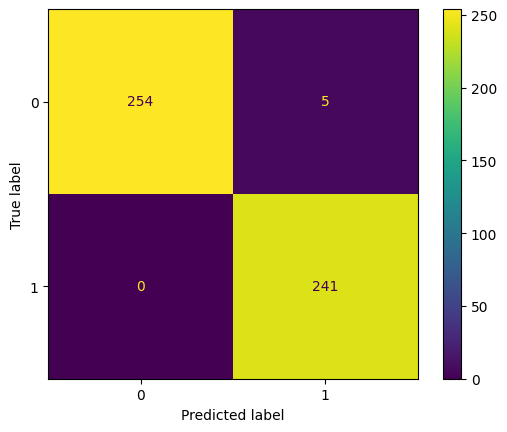

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = np.argmax(test_labels, axis=1)  #one-hot encoded labels to class labels
y_pred = np.argmax(property_model.predict(test_features), axis=1)

# confusion matrix
cm = confusion_matrix(y_true, y_pred)


disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()